In [661]:
import pandas as pd
import numpy as np
import datetime as dt
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.model_selection import train_test_split

# Przygotowanie danych

In [662]:
data = pd.read_csv("data.csv")

# Feature engeneering
data['avg_speed'] = data['avg_km']/data['avg_sec']*3600 # km/h
data['date_hour'] = pd.to_datetime(data['date_hour'])
data['month'] = data['date_hour'].dt.month
data['day'] = data['date_hour'].dt.day
data['hour'] = data['date_hour'].dt.hour
data['dayofweek'] = data['date_hour'].dt.dayofweek
data.drop(columns=['date_hour'], inplace=True)

In [663]:
holiday_dates = {
    (15,8),
    (20,9),
    (21,9),
    (3,10),
    (31,10),
    (1,11),
    (20,11),
    (25,12),
    (26,12)
}

def if_holiday(row):
    if (row['day'], row['month']) in holiday_dates:
        return 1
    else:
        return 0

data['holiday'] = data.apply(lambda row: if_holiday(row), axis=1)

In [664]:
data = data[['zone_id','month',
       'day', 'hour', 'dayofweek', 'holiday', 'n_rides', 'avg_sec',
       'avg_km', 'avg_speed','start_h3', 'end_h3','start_h3_centroid_lat', 'start_h3_centroid_lon',
       'end_h3_centroid_lat', 'end_h3_centroid_lon']]

# Eksploracja danych

In [665]:
data

,zone_id,month,day,hour,dayofweek,holiday,n_rides,avg_sec,avg_km,avg_speed,start_h3,end_h3,start_h3_centroid_lat,start_h3_centroid_lon,end_h3_centroid_lat,end_h3_centroid_lon
0,berlin,7,1,0,0,0,1,7204.408,1.009574,0.504478,8a1f1d4d0d5ffff,8a1f1d4d0057fff,52.515059,13.453406,52.511310,13.467112
1,berlin,7,1,0,0,0,1,6927.627,0.018491,0.009609,8a1f1d4f2557fff,8a1f1d4f2557fff,52.540292,13.416662,52.540292,13.416662
2,berlin,7,1,0,0,0,1,6596.358,1.535732,0.838134,8a1f1d4f255ffff,8a1f1d4899b7fff,52.540052,13.418495,52.532886,13.399084
3,berlin,7,1,0,0,0,1,7205.306,1.106335,0.552760,8a1f1d4f255ffff,8a1f1d48da4ffff,52.540052,13.418495,52.547429,13.406683
4,berlin,7,1,0,0,0,1,7201.344,0.339569,0.169753,8a1f1d4f640ffff,8a1f1d4f6577fff,52.554323,13.398535,52.557409,13.397211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611377,munich,12,31,15,1,0,1,612.658,0.865500,5.085707,8a1f8d7a482ffff,8a1f8d44b4cffff,48.138543,11.579964,48.140956,11.591940
611378,munich,12,31,16,1,0,1,1175.794,1.488641,4.557863,8a1f8d44a2c7fff,8a1f8d44a8d7fff,48.142891,11.578211,48.151346,11.561852
611379,munich,12,31,21,1,0,1,296.046,0.140860,1.712897,8a1f8d459057fff,8a1f8d4593b7fff,48.127069,11.552222,48.125741,11.554376
611380,munich,12,31,23,1,0,1,460.668,0.331242,2.588568,8a1f8d4593b7fff,8a1f8d459747fff,48.125741,11.554376,48.122721,11.553976


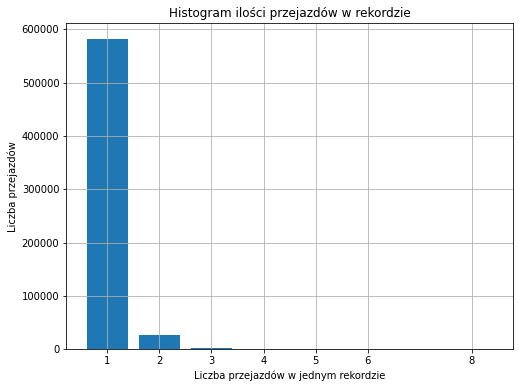

In [666]:
plt.figure(figsize=(8,6))
labels, counts = np.unique(data['n_rides'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.grid()
plt.xlabel('Liczba przejazdów w jednym rekordzie')
plt.ylabel('Liczba przejazdów')
plt.title('Histogram ilości przejazdów w rekordzie')
plt.savefig('1.png', bbox_inches='tight', facecolor="w")
plt.show()


Strefy są na tyle małe, że zazwyczaj jeden wiersz przedsttawia tylko jeden przejazd. Około 100m rozstawu między środkami stref.

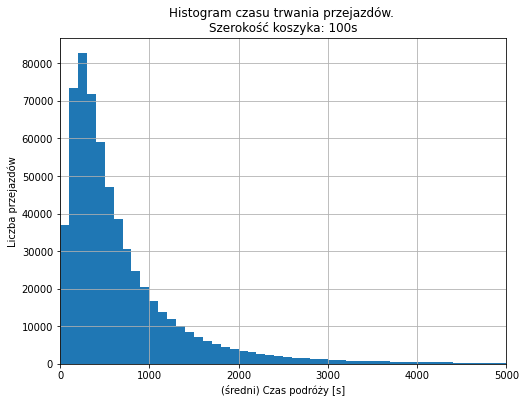

In [667]:
plt.figure(figsize=(8,6))
x_min = 0
x_max = 5000
plt.hist(data['avg_sec'],bins=50, range=(x_min, x_max))
plt.grid()
plt.xlim([x_min, x_max])
plt.xlabel('(średni) Czas podróży [s]')
plt.ylabel('Liczba przejazdów')
plt.title('Histogram czasu trwania przejazdów. \nSzerokość koszyka: 100s')
plt.savefig('2.png', bbox_inches='tight', facecolor="w")
plt.show()

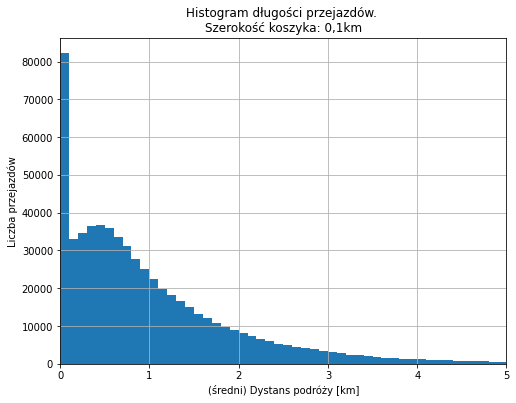

In [668]:
plt.figure(figsize=(8,6))
x_min = 0
x_max = 5
plt.hist(data['avg_km'],bins=50, range=(x_min, x_max))
plt.grid()
plt.xlim([x_min, x_max])
plt.xlabel('(średni) Dystans podróży [km]')
plt.ylabel('Liczba przejazdów')
plt.title('Histogram długości przejazdów. \nSzerokość koszyka: 0,1km')
plt.savefig('3.png', bbox_inches='tight', facecolor="w")
plt.show()

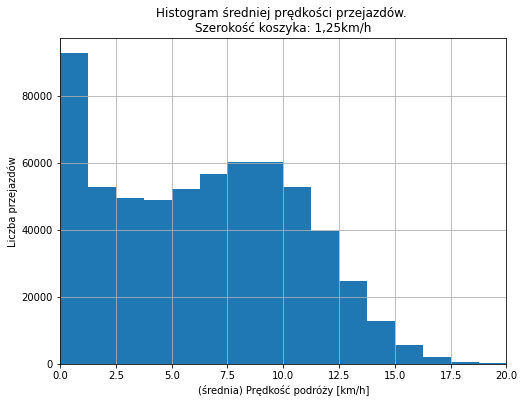

In [669]:
plt.figure(figsize=(8,6))
x_min = 0
x_max = 20
plt.hist(data['avg_speed'],bins=16, range=(x_min, x_max))
plt.grid()
plt.xlim([x_min, x_max])
plt.xlabel('(średnia) Prędkość podróży [km/h]')
plt.ylabel('Liczba przejazdów')
plt.title('Histogram średniej prędkości przejazdów. \nSzerokość koszyka: 1,25km/h')
plt.savefig('4.png', bbox_inches='tight', facecolor="w")
plt.show()

In [670]:
print(f"Unikalne strefy:\n Berlin {len(data[data['zone_id']=='berlin']['start_h3'].unique())}\n Monachium: {len(data[data['zone_id']=='munich']['start_h3'].unique())}")

Unikalne strefy:
 Berlin 7562
 Monachium: 3438


In [671]:
print(f"Liczba przejazdów:\n Berlin {len(data[data['zone_id']=='berlin']['n_rides'])}\n Monachium: {len(data[data['zone_id']=='munich']['n_rides'])}")

Liczba przejazdów:
 Berlin 364598
 Monachium: 246784


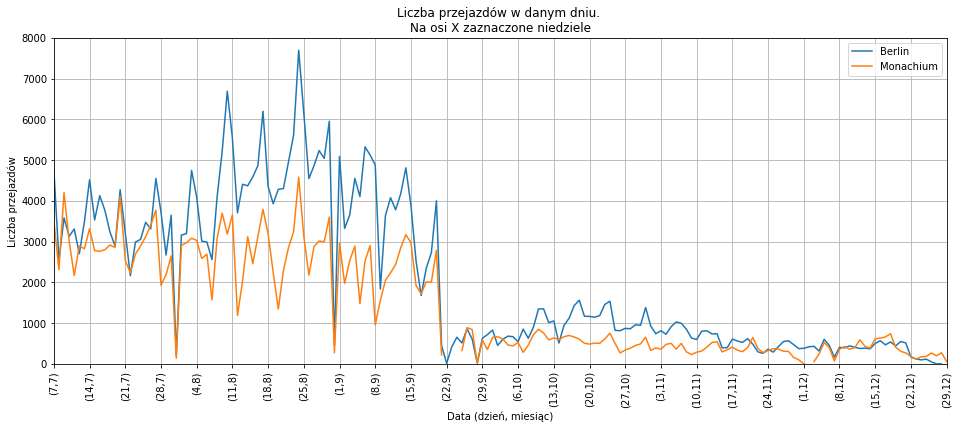

In [672]:
fig = pd.pivot_table(data, values=['n_rides'],  index=data[['month','day']], columns=['zone_id'], aggfunc='sum').plot(figsize=(16,6), xlabel='Data (dzień, miesiąc)', ylabel='Liczba przejazdów',
title='Liczba przejazdów w danym dniu. \nNa osi X zaznaczone niedziele', ylim=(0,8000), xlim=(7,12))
plt.xticks(range(6,182,7), ['(7,7)', '(14,7)', '(21,7)', '(28,7)', '(4,8)', '(11,8)', '(18,8)', '(25,8)', '(1,9)', '(8,9)', '(15,9)', '(22,9)', '(29,9)', '(6,10)', '(13,10)', '(20,10)', '(27,10)',
'(3,11)', '(10,11)', '(17,11)', '(24,11)', '(1,12)', '(8,12)', '(15,12)', '(22,12)', '(29,12)', ], rotation=90)
plt.legend(['Berlin', 'Monachium'])
plt.grid()
fig = fig.get_figure()
fig.savefig('5.png', bbox_inches='tight', facecolor="w")

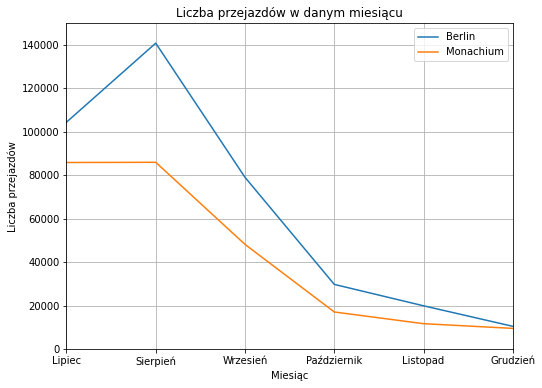

In [673]:
fig = pd.pivot_table(data, values=['n_rides'],  index=data['month'], columns=['zone_id'], aggfunc='sum').plot(figsize=(8,6), xlabel='Miesiąc', ylabel='Liczba przejazdów',
title='Liczba przejazdów w danym miesiącu', ylim=(0,150000), xlim=(7,12))
plt.xticks([7,8,9,10,11,12], ['Lipiec', 'Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień'], rotation=0)
plt.legend(['Berlin', 'Monachium'])
plt.grid()
fig = fig.get_figure()
fig.savefig('6.png', bbox_inches='tight', facecolor="w")

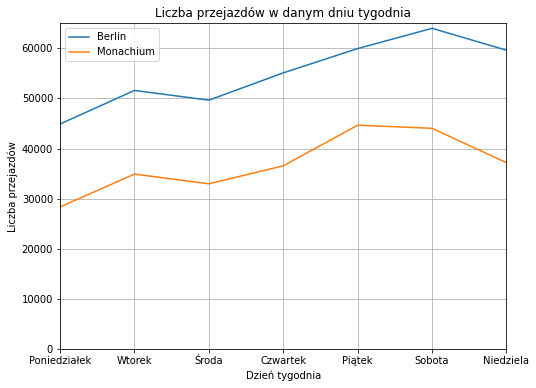

In [674]:
fig = pd.pivot_table(data, values=['n_rides'],  index=data[['dayofweek']], columns=['zone_id'], aggfunc='sum').plot(figsize=(8,6), xlabel='Dzień tygodnia', ylabel='Liczba przejazdów',
title='Liczba przejazdów w danym dniu tygodnia', ylim=(0,65000), xlim=(0,6))
plt.xticks([0,1,2,3,4,5,6], ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'], rotation=0)
plt.legend(['Berlin', 'Monachium'])
plt.grid()
fig = fig.get_figure()
fig.savefig('7.png', bbox_inches='tight', facecolor="w")

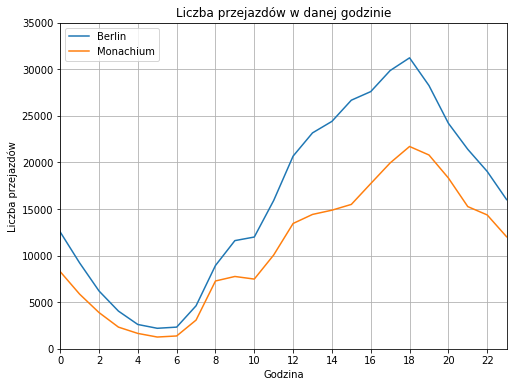

In [675]:
fig = pd.pivot_table(data, values=['n_rides'],  index=data[['hour']], columns=['zone_id'], aggfunc='sum').plot(figsize=(8,6), xlabel='Godzina', ylabel='Liczba przejazdów',
title='Liczba przejazdów w danej godzinie', ylim=(0,35000), xlim=(0,23))
plt.xticks(range(0,24,2))
plt.legend(['Berlin', 'Monachium'])
plt.grid()
fig = fig.get_figure()
fig.savefig('8.png', bbox_inches='tight', facecolor="w")

# Wizualizacja danych przestrzennych

In [676]:
def getRide(i):
    return  [[data['start_h3_centroid_lat'][i], data['start_h3_centroid_lon'][i]], [data['end_h3_centroid_lat'][i], data['end_h3_centroid_lon'][i]]]

rides = []
for i in range(30000):
    rides += [getRide(i)]

map = folium.Map(location=[52.540052, 13.418495])
folium.PolyLine(rides, color="red", weight=2.5, opacity=1).add_to(map)
map

Prosta wizualizacja pokazująca, gdzie się odbywają przejazdy.

# Heatmapa we własnej implementacji
Jak widać da się, ale trzeba jeszcze dopracować i potem opracować przeniesienie tych wyników na mapę. Wykorzystamy gotową funkcję do tworzenie heatmapy.

C:\Users\Maciej\AppData\Local\Temp/ipykernel_1660/3644267787.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Maciej\AppData\Local\Temp/ipykernel_1660/3644267787.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Maciej\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

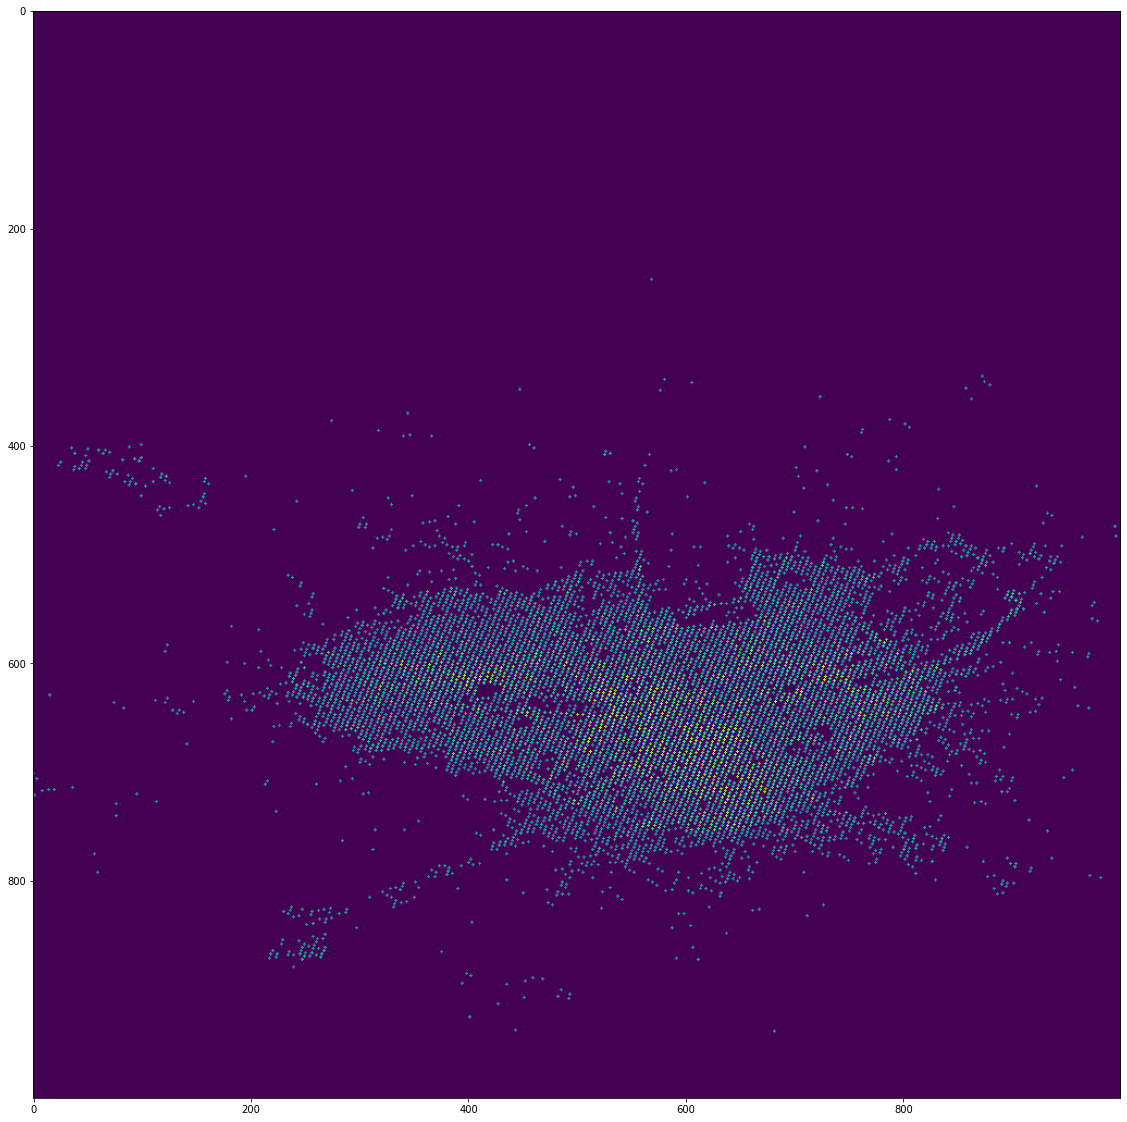

In [677]:
latCenter, lonCenter = 52.3, 13.2
zoom = 3
bins = 1000
heatMap = np.zeros(shape=(bins,bins))

BerlinData = data[data['zone_id']=='berlin']
BerlinData['x'] = np.round((BerlinData['start_h3_centroid_lat'] - latCenter)*bins*zoom)
BerlinData['y'] = np.round((BerlinData['start_h3_centroid_lon'] - lonCenter)*bins*zoom)
BerlinData.loc[(BerlinData['x'] >= 1000) | (BerlinData['x'] < 0), 'x'] = np.nan
BerlinData.loc[(BerlinData['y'] >= 1000) | (BerlinData['y'] < 0), 'y'] = np.nan
BerlinData.dropna(inplace=True)

BerlinData['x'] = BerlinData['x'].astype(int)
BerlinData['y'] = BerlinData['y'].astype(int)
BerlinData.reset_index(inplace=True)

dotx = np.array([-1,0,0,0,1])
doty = np.array([0,1,0,-1,0])

for i in range(len(BerlinData['y'])):
    heatMap[dotx+BerlinData['x'][i], doty+BerlinData['y'][i]] += 1
plt.figure(figsize=(20,20))
plt.imshow(np.log(heatMap+0.001))

# Heatmapa z gotowej funkcji

In [678]:
def generateHeatmap(data, mapCenter, zoom_start):
    heatMapDatastart = pd.pivot_table(data, values=['n_rides'],  index=['start_h3_centroid_lat','start_h3_centroid_lon'], aggfunc='sum').reset_index()
    heatMapDatastart.rename(columns={"start_h3_centroid_lat": "lat", "start_h3_centroid_lon": "lon"}, inplace=True)

    heatMapDataend = pd.pivot_table(data, values=['n_rides'],  index=['end_h3_centroid_lat','end_h3_centroid_lon'], aggfunc='sum').reset_index()
    heatMapDataend.rename(columns={"end_h3_centroid_lat": "lat", "end_h3_centroid_lon": "lon"}, inplace=True)
    heatMapData = pd.concat([heatMapDatastart, heatMapDataend])
    heatMapData = pd.pivot_table(heatMapData, values=['n_rides'],  index=['lat','lon'], aggfunc='sum').reset_index()

    map = folium.Map(location=mapCenter, zoom_start=zoom_start)
    hm = HeatMap(heatMapData, min_opacity=0.1, blur = 10).add_to(folium.FeatureGroup(name='Heat Map').add_to(map))
    return map

* Berlin

In [679]:
mapCenter = [52.540052, 13.418495]
zoom_start = 10
generateHeatmap(data[data['zone_id']=='berlin'], mapCenter, zoom_start)

* Monachium

In [680]:
mapCenter = [48.12, 11.57]
zoom_start = 10
generateHeatmap(data[data['zone_id']=='munich'], mapCenter, 12)

# Eksploracja danych poprzez uczenie maszynowe
Wykorzystaliśmy EBM - Explainable Boosting Machine, dają dobrą jakość i świetną wytłumaczalność do przewidywania liczby przejazdów.

In [681]:
dataMunich = data[data['zone_id']=='munich']
dataMunich = pd.pivot_table(dataMunich[['month', 'hour', 'dayofweek', 'holiday', 'n_rides']],index=['month', 'hour', 'dayofweek', 'holiday'], values=['n_rides'], aggfunc='sum').reset_index()
X = dataMunich[['month', 'hour', 'dayofweek', 'holiday']]
y = dataMunich['n_rides']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
ebm = ExplainableBoostingRegressor(random_state=2137)
ebm.fit(X_train, y_train)

preds = ebm.predict(X_test)
print(f"MAE: {np.mean(np.abs(preds-y_test))}")


ebm_global = ebm.explain_global()
show(ebm_global)

ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

# TODO
* podział na święta i dni robocze
* skorelować z pogodą, tzn temperatura wiatr, deszcz